In [1]:
import os
import pandas as pd
import datetime as dt
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
from distance import distance_calculator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.interpolate import RegularGridInterpolator
import multiprocessing

In [2]:
data_type = "MRMS"

# Enter time and Location

start_str = "2017-08-25 00:00:00"
end_str = "2017-09-01 00:00:00"

times_pd = pd.date_range(start=start_str,end=end_str, freq='1h')
times_pd = times_pd[0:-1]
desired_lon = 360-94.12
desired_lat = 30.08

In [3]:
filepaths = []
for i in times_pd: # Download all the desired IMERG Images
    # If IMERG file does not exist, download it
    
    year = i.strftime('%Y')
    month = i.strftime('%m')
    day =  i.strftime('%d')
    hour = i.strftime('%H')
    
    if (times_pd[0]).to_pydatetime() >= dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
        data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
            '/MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2'
        url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/MultiSensor_QPE_01H_Pass2/"\
            + 'MultiSensor_QPE_01H_Pass2_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'
        
    elif (times_pd[0]).to_pydatetime() < dt.datetime(2020,10,15): # Switch to dual-pol led to file directory change! Keep this in mind!
        data_file_path = '/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day+\
            '/GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2'
        url_desired = "https://mtarchive.geol.iastate.edu/"+year+"/"+month+"/"+day+"/mrms/ncep/GaugeCorr_QPE_01H/"\
            + 'GaugeCorr_QPE_01H_00.00_' + year+month+day+'-'+hour+'0000.grib2.gz'

# If day directory does not exist, make day directory
    if os.path.exists('/Users/acheung/data/MRMS/'+year) == False:
        os.mkdir('/Users/acheung/data/MRMS/'+year)

    if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month) == False:
        os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month)

    if os.path.exists('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day) == False:
        os.mkdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)

    if os.path.exists(data_file_path) == False:

        os.chdir('/Users/acheung/data/MRMS/'+year+'/'+month +'/'+ day)

        os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                  + url_desired)
        
        os.system('gzip -d '+data_file_path+'.gz')
    filepaths.append(data_file_path)


In [ ]:
# for case_loop in range(len(filepaths)): # Run all
#     ground_based_data = xr.open_dataset(filepaths[case_loop], engine="cfgrib")['unknown']
#     x, y = np.float32(np.meshgrid(ground_based_data['longitude'], ground_based_data['latitude']))


#     # Find index closest to interpolated best-track center or 2-km radar center
#     distance_arr = distance_calculator(x,y,(desired_lon,desired_lat))

#     abs_dist_arr = (abs(distance_arr))

#     min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

#     # Slice arrays to within 30 indices of desired center

#     sliced_lon_grid = x[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

#     sliced_lat_grid = y[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

#     sliced_ground_based_data = ground_based_data[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]
    
#     if case_loop == 0:
#         ground_total_precip = sliced_ground_based_data
#     else:
#         ground_total_precip = ground_total_precip + sliced_ground_based_data

In [51]:
# Use multiprocessing to slice MRMS or Stage IV Data (speeds up process significantly)

def slicing_file(case_loop,ground_total_precip,filepaths,desired_lon,desired_lat,sliced_lon_arr,sliced_lat_arr):
    import numpy as np
    import xarray as xr
    import sys
    sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')
    from distance import distance_calculator
    
    ground_based_data = xr.open_dataset(filepaths[case_loop], engine="cfgrib")['unknown']
    x, y = np.float32(np.meshgrid(ground_based_data['longitude'], ground_based_data['latitude']))


    # Find index closest to interpolated best-track center or 2-km radar center
    distance_arr = distance_calculator(x,y,(desired_lon,desired_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

    # Slice arrays to within 30 indices of desired center

    sliced_lon_grid = x[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

    sliced_lat_grid = y[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]

    sliced_ground_based_data = ground_based_data[min_dist_ind[0][0]-400:min_dist_ind[0][0]+400,min_dist_ind[1][0]-400:min_dist_ind[1][0]+400]
    ground_total_precip[case_loop] = sliced_ground_based_data.values
    
    if case_loop == 0: # Only grab lat/lon array once for plotting later
        sliced_lat_arr[case_loop] = sliced_ground_based_data['latitude']
        sliced_lon_arr[case_loop] = sliced_ground_based_data['longitude']

if __name__ == "__main__": # Run multiprocesses
    manager = multiprocessing.Manager()
    ground_total_precip = manager.dict()
    sliced_lat_arr = manager.dict()
    sliced_lon_arr = manager.dict()
    jobs = []
    for i in range(len(filepaths)):
        p = multiprocessing.Process(target=slicing_file, args=(i, ground_total_precip,filepaths,desired_lon,desired_lat,
                                                               sliced_lon_arr,sliced_lat_arr))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
# Sum up precipitation (MRMS data is hourly QPE)
summed_precip = np.sum(np.asarray(ground_total_precip.values()),axis=0)

Text(0.5, 1.0, 'MRMS Precipitation: \n Start: 2017-08-25 00:00:00; End: 2017-09-01 00:00:00')

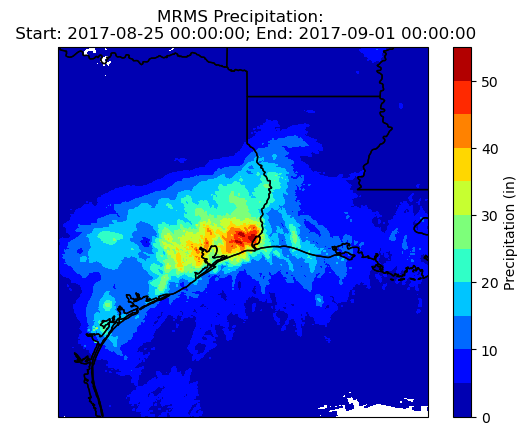

In [78]:
# Plot MRMS Data before interpolation
ax=plt.axes(projection=ccrs.PlateCarree())
precip_plot = ax.contourf(sliced_lon_arr[0],sliced_lat_arr[0],
                          summed_precip/25.4,transform = ccrs.PlateCarree(),cmap='jet',
                         levels=np.arange(0,55.1,5))
plt.colorbar(precip_plot,label='Precipitation (in)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title(data_type+' Precipitation: \n Start: ' + start_str + '; End: ' + end_str)

In [84]:
# Open IMERG Data Processed From Other Notebook

imerg_precip_data = xr.open_dataset('/Users/acheung/data/intermediates/start = '+start_str+', end = '+end_str+' imerg.nc')

converted_long = sliced_lon_arr[0] - 360

x_grid, y_grid = np.float32(np.meshgrid(converted_long, sliced_lat_arr[0]))

# Interpolate MRMS data to IMERG Grid Resolution
interpolater = RegularGridInterpolator((sliced_lat_arr[0].values,converted_long.values),
                                              summed_precip,bounds_error=False)

interpolated_ground_data = interpolater((imerg_precip_data['lat'].values, imerg_precip_data['lon'].values))

Text(0.5, 1.0, 'Interpolated MRMS Precipitation: \n Start: 2017-08-25 00:00:00; End: 2017-09-01 00:00:00')

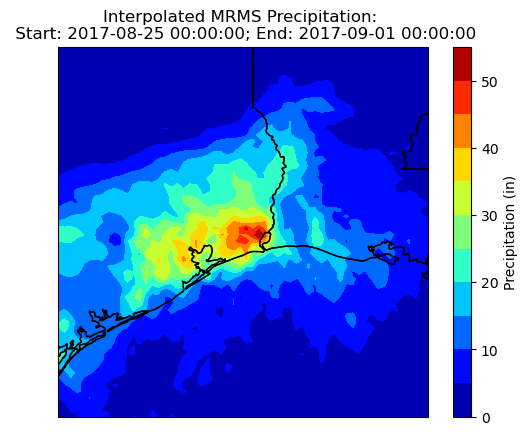

In [93]:
# Plot MRMS Data at IMERG Resolution
ax=plt.axes(projection=ccrs.PlateCarree())

interp_plot = ax.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,interpolated_ground_data/25.4,cmap='jet',
                         levels=np.arange(0,55.1,5),transform = ccrs.PlateCarree())
plt.colorbar(interp_plot,label='Precipitation (in)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('Interpolated '+ data_type +' Precipitation: \n Start: ' + start_str + '; End: ' + end_str)


Text(0.5, 1.0, 'IMERG Precipitation: \n Start: 2017-08-25 00:00:00; End: 2017-09-01 00:00:00')

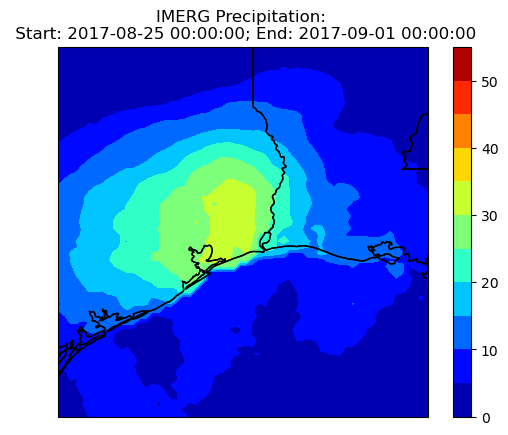

In [94]:
# Plot IMERG Precipitation
ax=plt.axes(projection=ccrs.PlateCarree())

interp_plot = ax.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,
                          imerg_precip_data['__xarray_dataarray_variable__']/25.4,cmap='jet',
                         levels=np.arange(0,55.1,5),transform = ccrs.PlateCarree())
plt.colorbar(interp_plot)
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title('IMERG Precipitation: \n Start: ' + start_str + '; End: ' + end_str)

Text(0.5, 1.0, 'MRMS and IMERG Precipitation Difference \n Start: 2017-08-25 00:00:00; End: 2017-09-01 00:00:00')

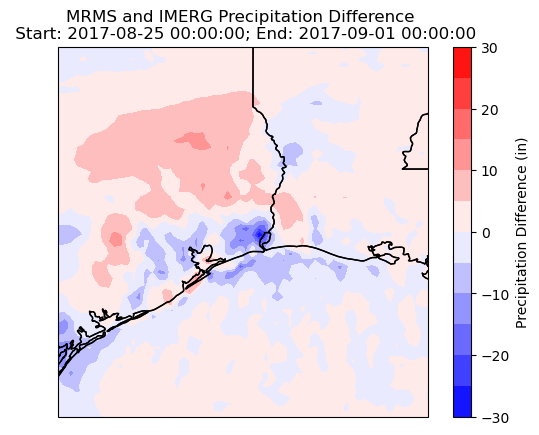

In [95]:
# Plot Difference Plot between MRMS and IMERG
ax=plt.axes(projection=ccrs.PlateCarree())

interp_plot = ax.contourf(imerg_precip_data['lon'].values,imerg_precip_data['lat'].values,
                          (imerg_precip_data['__xarray_dataarray_variable__']/25.4)-(interpolated_ground_data/25.4),cmap='bwr',
                         levels=np.arange(-30,30.1,5),transform = ccrs.PlateCarree())
plt.colorbar(interp_plot,label='Precipitation Difference (in)')
ax.add_feature(cfeature.STATES)
ax.add_feature(cfeature.COASTLINE)
ax.set_title(data_type + ' and IMERG Precipitation Difference' + ' \n Start: ' + start_str + '; End: ' + end_str)